# YZV311E Data Mining Project Data Preprocessing and Exploration
__________

### Hasan Taha Bağcı - 150210338
### Selman Turan Toker - 150220330
____________

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.data_preprocess import *
from utils.plots import *

import warnings
warnings.filterwarnings('ignore')


from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

## Reading the Data and Exploring Main Features

In [45]:
product_catalog = pd.read_csv('data/product_catalog.csv')
product_category_map = pd.read_csv('data/product_category_map.csv')
transactions = pd.read_csv('data/transactions.csv')
test = pd.read_csv('data/test.csv')

Shapes of the datasets are printed below.

In [46]:
print('product_catalog:', product_catalog.shape)
print('product_category_map:', product_category_map.shape)
print('transactions:', transactions.shape)


product_catalog: (32776, 8)
product_category_map: (4332, 2)
transactions: (1071538, 4)


In [47]:
final = transactions.merge(product_catalog, on='product_id', how='left')

In [48]:
final.head()

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]"
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]"
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]"
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,..."
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882..."


In [49]:

import ast

# Create a mapping from category_id to parent_category_id
category_to_parent = product_category_map.set_index('category_id')['parent_category_id'].to_dict()

# Function to map categories to their parent categories
def get_parent_categories(categories_str):
    if pd.isna(categories_str) or categories_str == '':
        return []
    # Convert string representation of list to an actual list
    categories = ast.literal_eval(categories_str)
    # Map each category to its parent
    parent_categories = [category_to_parent.get(cat_id, None) for cat_id in categories]
    # Remove None values if any category_id doesn't have a parent in the map
    return [parent for parent in parent_categories if parent is not None]

# Apply the function to add the parent_categories column
final['parent_categories'] = final['categories'].apply(get_parent_categories)


In [50]:
final_nulls_removed = final.dropna()
final_nulls_removed.isnull().sum()

customer_id          0
product_id           0
purchase_date        0
quantity             0
manufacturer_id      0
attribute_1          0
attribute_2          0
attribute_3          0
attribute_4          0
attribute_5          0
categories           0
parent_categories    0
dtype: int64

In [51]:

def fill_missing_category(row):
    if pd.isna(row['categories']):
        return row['parent_categories']
    return row['categories']



In [52]:

final["categories"] = final.apply(fill_missing_category, axis=1)
final_nulls_filled = final

In [53]:
# Get ready for the model split the data into train and test
final_nulls_filled['purchase_date'] = pd.to_datetime(final_nulls_filled['purchase_date'])

# Get the latest purchase date
latest_date = final_nulls_filled['purchase_date'].max()

# Calculate the days since purchase of each purchase
final_nulls_filled['days_since_purchase'] = latest_date - final_nulls_filled['purchase_date']

# Convert days since purchase to days
final_nulls_filled['days_since_purchase'] = final_nulls_filled['days_since_purchase'].dt.days



# Get the total number of purchases for each user
final_nulls_filled['total_purchases'] = final_nulls_filled.groupby('customer_id')['customer_id'].transform('count')

# Get the total number of unique products purchased by each user
final_nulls_filled['unique_products'] = final_nulls_filled.groupby('customer_id')['product_id'].transform('nunique')

In [54]:
final_nulls_filled_sorted = final_nulls_filled.sort_values(by=['customer_id', 'product_id'])
final_nulls_filled_sorted.head(100)
final_nulls_filled_sorted["total_unique_product_sold"] = final_nulls_filled_sorted.groupby(['customer_id','product_id'])['quantity'].transform('sum')
final_nulls_filled_sorted.head(100)
final_nulls_filled_sorted['last_purchase'] = final_nulls_filled_sorted.groupby(['customer_id', 'product_id'])['days_since_purchase'].transform('min')
final_nulls_filled_sorted=final_nulls_filled_sorted.reset_index(drop=True)
final_nulls_filled_sorted.shape







(1071538, 17)

In [55]:


recency_diff = final_nulls_filled_sorted.groupby(['customer_id', 'product_id']).agg(
    max_date=('days_since_purchase', 'max'),
    min_date=('days_since_purchase', 'min'),
    total_unique_product_sold=('total_unique_product_sold', 'first')
)


recency_diff['recency_div_product'] = (recency_diff['max_date'] - recency_diff['min_date']) / (recency_diff['total_unique_product_sold']) #+1 gelmesi lazım sona


final_nulls_filled_sorted = final_nulls_filled_sorted.merge(recency_diff['recency_div_product'].reset_index(), on=['customer_id', 'product_id'], how='left')
final_nulls_filled_sorted['recency_div_product'] = final_nulls_filled_sorted.apply(
    lambda row: int(row['days_since_purchase']) if row['recency_div_product'] == 0 else int(row['recency_div_product']), 
    axis=1
)

final_nulls_filled_sorted


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product
0,0,1505,2020-09-01,1,286,4,0,82,0,144,"[3392, 179, 1390, 563, 383, 1886]","[1374, 1062, 2762, 1666, 3439, 1062]",152,18,13,1,152,152
1,0,6446,2020-12-11,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",51,18,13,2,16,17
2,0,6446,2021-01-15,1,839,4,0,18,0,81,"[545, 1032, 3963]","[2012, 2924, 3898]",16,18,13,2,16,17
3,0,9325,2020-11-20,1,107,6,0,308,3,17,"[3024, 1772, 1136, 3882, 948, 4071]","[1682, 1682, 452, 264, 264, 3898]",72,18,13,1,72,72
4,0,12468,2020-08-03,1,1288,10,0,421,3,3,"[3224, 2690, 2700]","[2385, 1841, 1841]",181,18,13,1,181,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071533,46137,22403,2021-01-18,1,703,10,0,345,3,24,"[3766, 1515, 2389, 1174, 3173, 3625, 2872]","[3154, 621, 1739, 1678, 2542, 2346, 2369]",13,10,10,1,13,13
1071534,46137,22583,2021-01-31,1,449,6,0,179,0,122,"[585, 74, 3960]","[3056, 3056, 3898]",0,10,10,1,0,0
1071535,46137,28343,2020-08-08,1,842,10,1,503,0,137,"[1212, 210, 2320, 152, 3495]","[3288, 3451, 3451, 3346, 687]",176,10,10,1,176,176
1071536,46137,28900,2020-08-08,2,1156,10,0,137,3,87,"[2951, 1763, 3915, 3914, 4065, 1971]","[3565, 3898, 3898, 3898, 3898, 3289]",176,10,10,2,176,176


In [56]:
final_nulls_filled_sorted.loc[final_nulls_filled_sorted['last_purchase'] < 28].shape


(221594, 18)

In [57]:
final_nulls_filled_sorted = final_nulls_filled_sorted.sort_values(by=['customer_id', 'product_id', 'purchase_date'])

#Find the next purchase date
final_nulls_filled_sorted['next_purchase_date'] = final_nulls_filled_sorted.groupby(['customer_id', 'product_id'])['purchase_date'].shift(-1)
final_nulls_filled_sorted['next_purchase_days'] = (final_nulls_filled_sorted['next_purchase_date'] - final_nulls_filled_sorted['purchase_date']).dt.days
copy_to_test = final_nulls_filled_sorted.copy

final_nulls_filled_sorted.head(55)

# Turn days to weeks
final_nulls_filled_sorted['next_purchase_weeks'] = final_nulls_filled_sorted['next_purchase_days'].apply(
    lambda x: -1 if pd.isna(x)  else (0 if (x // 7) + 1 > 4 else (x // 7) + 1)
)



final_nulls_filled_sorted['next_purchase_weeks'] = final_nulls_filled_sorted['next_purchase_weeks'].astype(int)


#nun = final_nulls_filled_sorted[final_nulls_filled_sorted["next_purchase_weeks"] == -1].shape[0]
#print(nun)

#final_nulls_filled_sorted.shape
final_nulls_filled_sorted.head()



,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,...,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product,next_purchase_date,next_purchase_days,next_purchase_weeks
0,0,1505,2020-09-01,1,286,4,0,82,0,144,...,"[1374, 1062, 2762, 1666, 3439, 1062]",152,18,13,1,152,152,NaT,NaN,-1
1,0,6446,2020-12-11,1,839,4,0,18,0,81,...,"[2012, 2924, 3898]",51,18,13,2,16,17,2021-01-15,35.0,0
2,0,6446,2021-01-15,1,839,4,0,18,0,81,...,"[2012, 2924, 3898]",16,18,13,2,16,17,NaT,NaN,-1
3,0,9325,2020-11-20,1,107,6,0,308,3,17,...,"[1682, 1682, 452, 264, 264, 3898]",72,18,13,1,72,72,NaT,NaN,-1
4,0,12468,2020-08-03,1,1288,10,0,421,3,3,...,"[2385, 1841, 1841]",181,18,13,1,181,181,NaT,NaN,-1


In [58]:
final_nulls_filled_sorted = final_nulls_filled_sorted[final_nulls_filled_sorted["next_purchase_weeks"] != -1]
final_nulls_filled_sorted

,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,...,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product,next_purchase_date,next_purchase_days,next_purchase_weeks
1,0,6446,2020-12-11,1,839,4,0,18,0,81,...,"[2012, 2924, 3898]",51,18,13,2,16,17,2021-01-15,35.0,0
8,0,20664,2020-06-05,1,408,4,0,284,0,66,...,"[2054, 1303]",240,18,13,3,51,63,2020-10-09,126.0,0
9,0,20664,2020-10-09,1,408,4,0,284,0,66,...,"[2054, 1303]",114,18,13,3,51,63,2020-12-11,63.0,0
12,0,28231,2020-11-20,1,193,4,3,468,3,108,...,"[1682, 3898, 3898]",72,18,13,4,6,16,2020-12-11,21.0,4
13,0,28231,2020-12-11,1,193,4,3,468,3,108,...,"[1682, 3898, 3898]",51,18,13,4,6,16,2021-01-25,45.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1071444,46133,17645,2020-11-14,1,1105,4,0,486,0,48,...,"[3706, 3565, 1751, 3122, 3898, 3898, 3898, 389...",78,25,21,2,17,30,2021-01-14,61.0,0
1071475,46134,21901,2020-07-26,1,1433,4,0,291,0,44,...,"[1682, 1565, 1557, 3819, 3898, 3898, 3898]",189,29,28,3,138,17,2020-09-15,51.0,0
1071493,46136,1782,2020-06-27,4,6,4,3,321,0,144,...,"[3488, 3726, 3045, 2302, 2599, 2191, 3781, 323...",218,35,32,9,34,20,2020-12-28,184.0,0
1071522,46136,29657,2020-06-27,5,18,10,0,345,0,84,...,"[621, 380, 2762, 489, 2542, 2542, 3898, 3898, ...",218,35,32,10,34,18,2020-12-28,184.0,0


In [59]:
non_zero_rows = final_nulls_filled_sorted[final_nulls_filled_sorted['next_purchase_weeks'] != 0]
non_zero_rows.shape

(26413, 21)

In [60]:
test_arrangment = final_nulls_filled_sorted.copy()

zero_rows = final_nulls_filled_sorted[final_nulls_filled_sorted['next_purchase_weeks'] == 0]

non_zero_rows = final_nulls_filled_sorted[final_nulls_filled_sorted['next_purchase_weeks'] != 0]

sampled_zero_rows = zero_rows.sample(frac=0.05, random_state=42)

final_result = pd.concat([non_zero_rows, sampled_zero_rows])
final_result.shape



(33848, 21)

In [61]:
final_result.columns

Index(['customer_id', 'product_id', 'purchase_date', 'quantity',
       'manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3',
       'attribute_4', 'attribute_5', 'categories', 'parent_categories',
       'days_since_purchase', 'total_purchases', 'unique_products',
       'total_unique_product_sold', 'last_purchase', 'recency_div_product',
       'next_purchase_date', 'next_purchase_days', 'next_purchase_weeks'],
      dtype='object')

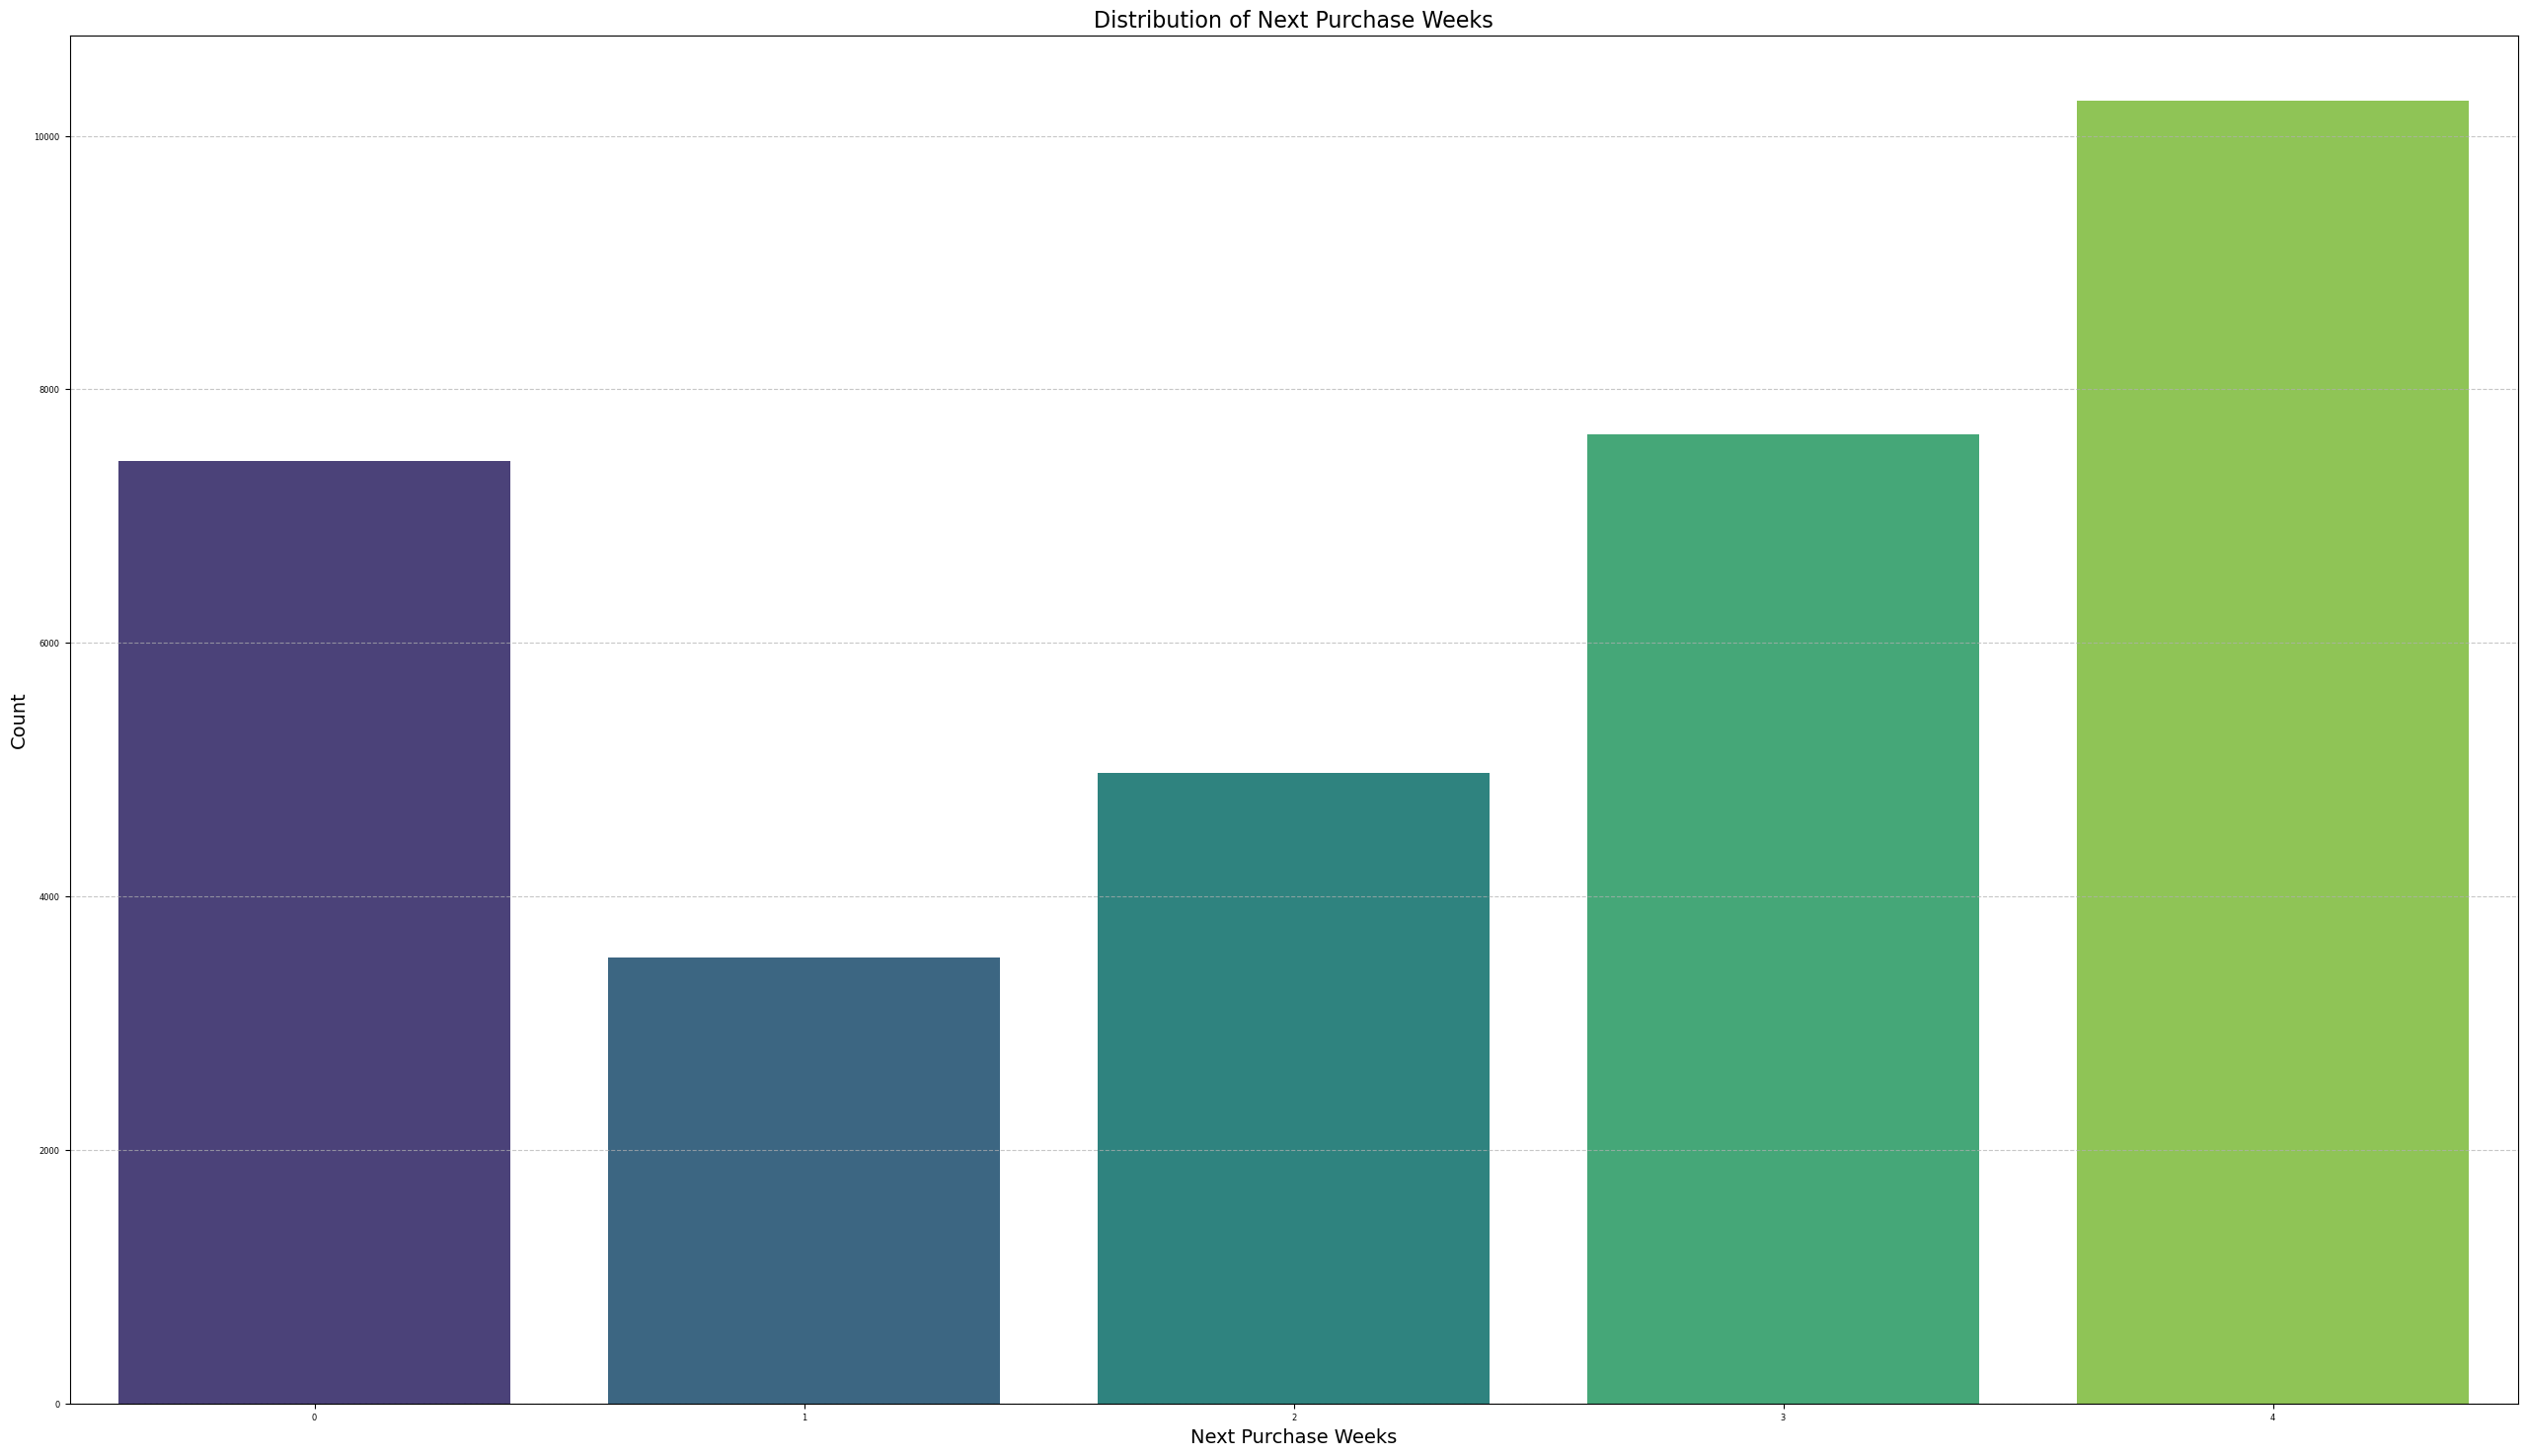

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(32, 18))
sns.countplot(x='next_purchase_weeks', data=final_result, palette="viridis")

plt.title('Distribution of Next Purchase Weeks', fontsize=16)
plt.xlabel('Next Purchase Weeks', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [63]:
final_nulls_filled_sorted = final_result
final_nulls_filled_sorted.shape

(33848, 21)

In [64]:
#we don't need date data anymore because we have recency data
final_nulls_filled_droped =final_nulls_filled_sorted.drop(["purchase_date","categories","next_purchase_date","next_purchase_days"],axis=1)
test_arrangment =test_arrangment.drop(["purchase_date","next_purchase_date","categories","next_purchase_days"],axis=1)


In [65]:

print(final_nulls_filled_droped.columns)
print(final_nulls_filled_droped.shape)


Index(['customer_id', 'product_id', 'quantity', 'manufacturer_id',
       'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4',
       'attribute_5', 'parent_categories', 'days_since_purchase',
       'total_purchases', 'unique_products', 'total_unique_product_sold',
       'last_purchase', 'recency_div_product', 'next_purchase_weeks'],
      dtype='object')
(33848, 17)


In [66]:
final_nulls_filled_droped.reset_index(drop=True,inplace=True)
test_arrangment.reset_index(drop=True,inplace=True)

test_arrangment

,customer_id,product_id,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,parent_categories,days_since_purchase,total_purchases,unique_products,total_unique_product_sold,last_purchase,recency_div_product,next_purchase_weeks
0,0,6446,1,839,4,0,18,0,81,"[2012, 2924, 3898]",51,18,13,2,16,17,0
1,0,20664,1,408,4,0,284,0,66,"[2054, 1303]",240,18,13,3,51,63,0
2,0,20664,1,408,4,0,284,0,66,"[2054, 1303]",114,18,13,3,51,63,0
3,0,28231,1,193,4,3,468,3,108,"[1682, 3898, 3898]",72,18,13,4,6,16,4
4,0,28231,1,193,4,3,468,3,108,"[1682, 3898, 3898]",51,18,13,4,6,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175107,46133,17645,1,1105,4,0,486,0,48,"[3706, 3565, 1751, 3122, 3898, 3898, 3898, 389...",78,25,21,2,17,30,0
175108,46134,21901,1,1433,4,0,291,0,44,"[1682, 1565, 1557, 3819, 3898, 3898, 3898]",189,29,28,3,138,17,0
175109,46136,1782,4,6,4,3,321,0,144,"[3488, 3726, 3045, 2302, 2599, 2191, 3781, 323...",218,35,32,9,34,20,0
175110,46136,29657,5,18,10,0,345,0,84,"[621, 380, 2762, 489, 2542, 2542, 3898, 3898, ...",218,35,32,10,34,18,0


In [67]:
final_nulls_filled_droped.shape

(33848, 17)

In [68]:
X = final_nulls_filled_droped.drop(["next_purchase_weeks"],axis=1)

y = final_nulls_filled_droped['next_purchase_weeks']  


In [69]:

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(X['parent_categories'])

category_columns = mlb.classes_
X = pd.concat([X.drop(columns=['parent_categories']), pd.DataFrame(categories_encoded, columns=category_columns)], axis=1)


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=41)




In [71]:
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=17,      
    random_state=42    
)


rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy:.4f}")


print(classification_report(y_test, y_pred))



import joblib
joblib.dump(rf_model, 'rf_model.pkl')
"""


'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.metrics import accuracy_score, classification_report\n\nrf_model = RandomForestClassifier(\n    n_estimators=100,  \n    max_depth=17,      \n    random_state=42    \n)\n\n\nrf_model.fit(X_train, y_train)\n\n\ny_pred = rf_model.predict(X_test)\n\n\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"acc: {accuracy:.4f}")\n\n\nprint(classification_report(y_test, y_pred))\n\n\n\nimport joblib\njoblib.dump(rf_model, \'rf_model.pkl\')\n'

In [72]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import joblib


from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,         
    max_depth=3,             
    learning_rate=0.01,        
    objective='multi:softmax',
    random_state=41           
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"acc: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


joblib.dump(xgb_model, 'xgb_model_custom.pkl')


acc: 0.5908
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       176
           1       0.94      0.59      0.72        87
           2       0.76      0.45      0.56        92
           3       0.51      0.28      0.36       145
           4       0.43      0.79      0.56       177

    accuracy                           0.59       677
   macro avg       0.68      0.57      0.59       677
weighted avg       0.64      0.59      0.59       677



['xgb_model_custom.pkl']

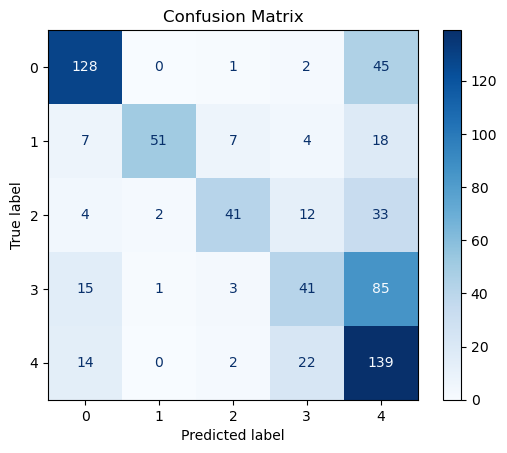

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [74]:
test_data = test

final_unique = test_arrangment.drop_duplicates(subset=['customer_id', 'product_id'])
final_unique.shape
test_data_filled = final_unique[
    final_unique[['customer_id', 'product_id']].apply(tuple, axis=1).isin(
        test_data[['customer_id', 'product_id']].apply(tuple, axis=1)
    )
]
test_data_filled['days_since_purchase'] = test_data_filled["last_purchase"]
test_data_droped = test_data_filled.drop(["next_purchase_weeks"],axis=1)
test_data_droped.reset_index(drop=True, inplace=True)




In [75]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

# Transform the test set using the previously trained MultiLabelBinarizer (mlb) model
test_final_mlb = mlb.transform(test_data_droped['parent_categories'])

# match column names
mlb_columns = mlb.classes_


test_final = pd.concat([
    test_data_droped.reset_index(drop=True),  
    pd.DataFrame(test_final_mlb, columns=mlb_columns)  
], axis=1)


test_final = test_final.drop(columns=['parent_categories'], errors='ignore')


In [76]:
import pandas as pd
import joblib

model = joblib.load('xgb_model_custom.pkl')

y_pred = model.predict(test_final)

test_final['prediction'] = y_pred
test_final


,customer_id,product_id,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,days_since_purchase,...,3849,3852,3859,3860,3869,3870,3884,3891,3898,prediction
0,0,20664,1,408,4,0,284,0,66,51,...,0,0,0,0,0,0,0,0,0,1
1,0,28231,1,193,4,3,468,3,108,6,...,0,0,0,0,0,0,0,0,1,1
2,13,2690,1,406,4,3,491,0,66,38,...,0,0,0,0,0,0,0,0,0,4
3,15,1299,1,1056,4,0,474,-1,108,17,...,0,0,0,0,0,0,0,0,1,3
4,15,20968,1,1315,4,0,444,0,144,6,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,46118,20106,1,1111,4,0,491,0,66,39,...,0,0,0,0,0,0,0,0,1,4
9996,46124,19677,1,1006,4,0,491,3,154,8,...,0,0,0,0,0,0,0,0,0,1
9997,46125,12878,1,1111,4,0,491,0,66,0,...,0,0,0,0,0,0,0,0,1,1
9998,46127,7963,2,1111,4,0,485,3,154,48,...,0,0,0,0,0,0,0,0,0,4


In [77]:
"""
import joblib

model = joblib.load('rf_model.pkl')
#feature_selector = joblib.load('feature_selector.pkl')

#train_columns = feature_selector.get_support(indices=True)
#test_selected = feature_selector.transform(test_data_droped)
#y_pred = model.predict(test_selected)

y_pred = model.predict(test_final)


print(y_pred)



test['prediction'] = y_pred
test
"""


"\nimport joblib\n\nmodel = joblib.load('rf_model.pkl')\n#feature_selector = joblib.load('feature_selector.pkl')\n\n#train_columns = feature_selector.get_support(indices=True)\n#test_selected = feature_selector.transform(test_data_droped)\n#y_pred = model.predict(test_selected)\n\ny_pred = model.predict(test_final)\n\n\nprint(y_pred)\n\n\n\ntest['prediction'] = y_pred\ntest\n"

In [78]:
test_final["prediction"]

0       1
1       1
2       4
3       3
4       1
       ..
9995    4
9996    1
9997    1
9998    4
9999    4
Name: prediction, Length: 10000, dtype: int32

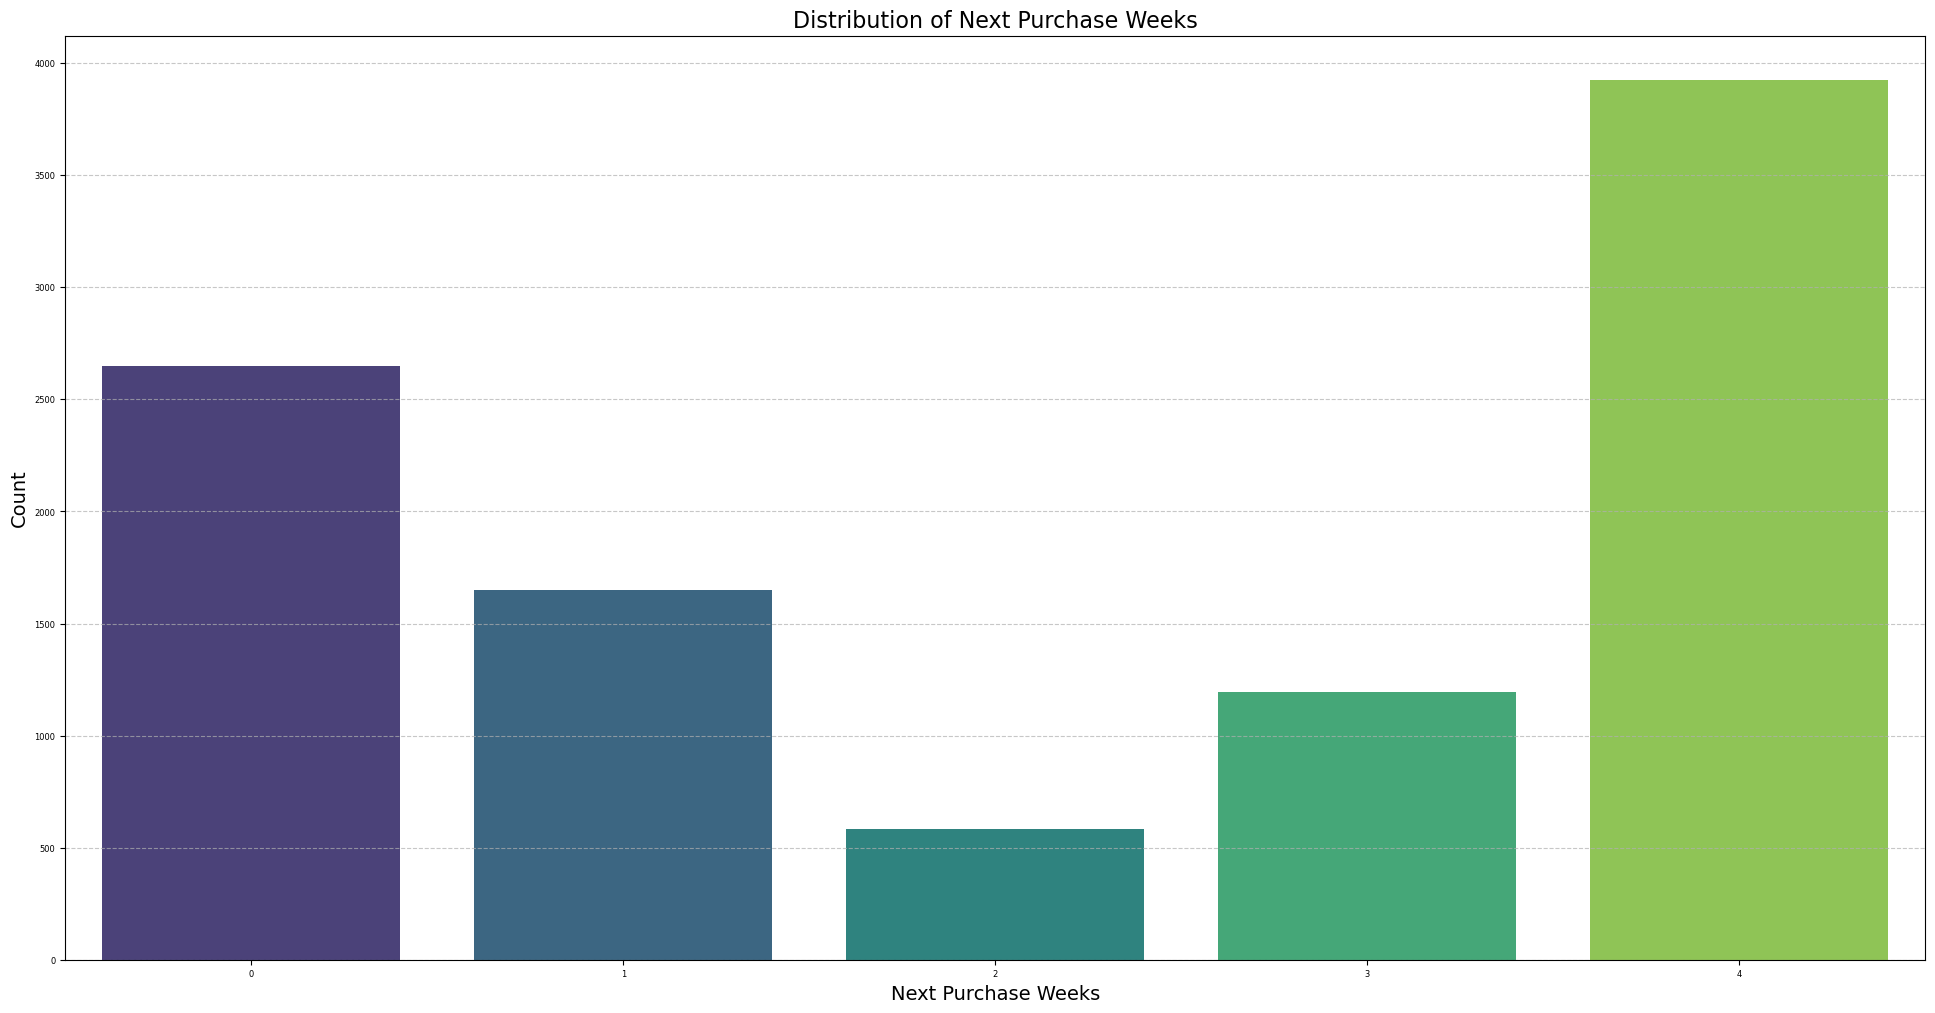

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24, 12))
sns.countplot(x='prediction', data=test_final, palette="viridis")

plt.title('Distribution of Next Purchase Weeks', fontsize=16)
plt.xlabel('Next Purchase Weeks', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



In [80]:
test['prediction'] = y_pred

test.to_csv('predictions.csv', index=False)
